<a href="https://colab.research.google.com/github/nivethithanm/finetuning_distilbert_for_toxic_comment_classification/blob/main/DistilBERT_Toxicity_FineTuning_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets==3.6

In [ ]:
# Imports
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%matplotlib inline

In [ ]:
# Set device and seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Initialize WandB
wandb.login()  # Requires API key in Colab
wandb.init(project="distilbert-hatexplain-classification")

In [ ]:
# Config
config = {
    "model_name": "distilbert-base-uncased",
    "max_length": 512,
    "batch_size": 32,
    "epochs": 3,
    "lr": 2e-4,
    "lora_r": 16,
    "lora_alpha": 32,
    "lora_dropout": 0.1,
    "lora_target_modules": ["q_lin", "v_lin"],
    "weight_decay": 0.01,
    "gradient_accumulation_steps": 4
}

In [ ]:
# Preprocess Text
def preprocess_text(text):
    text = text.lower().replace(r"http\S+", "").replace(r"[^a-zA-Z0-9\s]", "")
    return text

In [ ]:
# Process Dataset
dataset = load_dataset("hatexplain", trust_remote_code=True)
labels_list = ["toxic", "hatespeech", "offensive"]

# Preprocess and map labels
def map_labels(examples):
    # Map HateXplain's labels to multi-label format
    label = examples["annotators"]['label']

    if 0 in label:
        labels_array = np.array([1, 1, 0], dtype=np.float32)  # toxic, hatespeech
    elif 2 in label:
        labels_array = np.array([1, 0, 1], dtype=np.float32)  # toxic, offensive
    else:
        labels_array = np.array([0, 0, 0], dtype=np.float32)  # normal, fallback
    examples["labels"] = labels_array
    examples["text"] = preprocess_text(" ".join(examples["post_tokens"]))
    return examples

dataset = dataset.map(map_labels)

In [ ]:
# Split data
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [ ]:
# Tokenize
tokenizer = AutoTokenizer.from_pretrained(config["model_name"])

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=config["max_length"],
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Verify label type and shape
print("Sample labels type:", train_dataset[0]["labels"].dtype)  # Should be torch.float32
print("Sample labels shape:", train_dataset[0]["labels"].shape)  # Should be (3,)

Sample labels type: torch.float32
Sample labels shape: torch.Size([3])


In [ ]:
# Model Initialization
model = AutoModelForSequenceClassification.from_pretrained(
    config["model_name"],
    num_labels=len(labels_list),
    problem_type="multi_label_classification",
)
model.to(device)

In [ ]:
# Apply LoRA (target DistilBERT's attention layers)
lora_config = LoraConfig(
    r=config["lora_r"],
    lora_alpha=config["lora_alpha"],
    target_modules=config["lora_target_modules"],  # DistilBERT-specific attention modules
    lora_dropout=config["lora_dropout"],
    bias="none",
)
model = get_peft_model(model, lora_config)
model.to(device)

In [ ]:
# Analyze label distribution
label_counts_train = np.sum(np.stack(train_dataset["labels"]), axis=0)
label_counts_val = np.sum(np.stack(val_dataset["labels"]), axis=0)
total_train = len(train_dataset)
total_val = len(val_dataset)

print("Label distribution (train):")
for label, count in zip(labels_list, label_counts_train):
    print(f"{label}: {count} positive examples ({count/total_train*100:.2f}%)")

print("\nLabel distribution (validation):")
for label, count in zip(labels_list, label_counts_val):
    print(f"{label}: {count} positive examples ({count/total_val*100:.2f}%)")

Label distribution (train):
toxic: 11287.0 positive examples (73.37%)
hatespeech: 6608.0 positive examples (42.96%)
offensive: 4679.0 positive examples (30.42%)

Label distribution (validation):
toxic: 1398.0 positive examples (72.74%)
hatespeech: 808.0 positive examples (42.04%)
offensive: 590.0 positive examples (30.70%)


In [ ]:
# Compute class weights
label_counts = np.sum(np.stack(train_dataset["labels"]), axis=0)
class_weights = torch.tensor(1.0 / (label_counts + 1e-6), dtype=torch.float32).to(device)
print("Class weights:", dict(zip(labels_list, class_weights.tolist())))

Class weights: {'toxic': 8.85975023265928e-05, 'hatespeech': 0.0001513317256467417, 'offensive': 0.0002137208794010803}


In [ ]:
# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy()
    labels = labels.astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    roc_auc = []
    for i in range(len(labels[0])):
        try:
            roc_auc.append(roc_auc_score(labels[:, i], logits[:, i]))
        except ValueError:
            roc_auc.append(0.0)  # Handle cases with no positive samples
    micro_f1 = precision_recall_fscore_support(labels, predictions, average="micro")[2]
    macro_f1 = precision_recall_fscore_support(labels, predictions, average="macro")[2]
    accuracy = accuracy_score(labels, predictions)

    return {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "accuracy": accuracy,
        **{f"f1_{labels_list[i]}": f1[i] for i in range(len(labels[0]))},  # Use labels_list
        **{f"roc_auc_{labels_list[i]}": roc_auc[i] for i in range(len(labels[0]))},  # Use labels_list
    }

In [ ]:
def test_compute_metrics():
    import numpy as np

    # Example eval_pred
    logits = np.array([
        [ 0.5, -0.2,  1.0],  # Example 1: Logits for [toxic, hatespeech, offensive]
        [-1.0,  0.8, -0.5],  # Example 2
        [ 0.3,  0.1,  0.4],  # Example 3
        [-0.7, -0.9, -1.2],  # Example 4
    ], dtype=np.float32)

    labels = np.array([
        [1.0, 1.0, 0.0],  # Example 1: hatespeech → [toxic, hatespeech]
        [1.0, 0.0, 1.0],  # Example 2: offensive → [toxic, offensive]
        [0.0, 0.0, 0.0],  # Example 3: normal → []
        [0.0, 0.0, 0.0],  # Example 4: normal → []
    ], dtype=np.float32)

    eval_pred = (logits, labels)

    return compute_metrics(eval_pred)

In [ ]:
# Training
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=config["epochs"],
    per_device_train_batch_size=config["batch_size"],
    per_device_eval_batch_size=config["batch_size"],
    gradient_accumulation_steps=config["gradient_accumulation_steps"],
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=config["lr"],
    weight_decay=config["weight_decay"],
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_dir="./logs",
    logging_steps=10,
    report_to="wandb",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
# Evaluation
test_results = trainer.predict(test_dataset)
predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.5).numpy()
labels = test_results.label_ids.astype(int)

In [ ]:
# Sample predictions
sample_df = pd.DataFrame({
    "Text": test_dataset["text"][:10],
    "True Labels": [labels[i] for i in range(10)],
    "Predicted Labels": [predictions[i] for i in range(10)],
    "Confidence": [torch.sigmoid(torch.tensor(test_results.predictions[i])).numpy() for i in range(10)],
})
display(sample_df)

,Text,True Labels,Predicted Labels,Confidence
0,<user> men can not be raped can not be abused ...,"[0, 0, 0]","[False, False, False]","[0.43506128, 0.17667161, 0.38093165]"
1,<user> you are missing an essential premise wh...,"[1, 0, 1]","[True, False, False]","[0.6525736, 0.23318209, 0.3706809]"
2,<user> <user> why are you repeating yourself a...,"[1, 0, 1]","[False, False, False]","[0.44990614, 0.1538032, 0.38682136]"
3,<user> <user> well she ’ muslim so of course s...,"[1, 1, 0]","[True, False, False]","[0.7014064, 0.24653332, 0.31478733]"
4,<user> lol not me i don ’ t deal with bms not ...,"[1, 1, 0]","[False, False, False]","[0.46952024, 0.15817435, 0.37410447]"
5,an these nigger biches look like godzilla nasty,"[1, 1, 0]","[True, True, False]","[0.852199, 0.8010035, 0.21866935]"
6,yeah humnh what how do i use this app i ’ m al...,"[1, 0, 1]","[True, False, False]","[0.58788395, 0.17852582, 0.42030215]"
7,black people are oppressed by their own cultur...,"[1, 0, 1]","[True, False, False]","[0.8130158, 0.46183583, 0.3351332]"
8,education or marxist indoctrination since it i...,"[1, 1, 0]","[True, False, False]","[0.7627777, 0.35197902, 0.35220176]"
9,fell outta love and found a boss bitch,"[0, 0, 0]","[True, False, False]","[0.6460137, 0.21950476, 0.45444188]"


In [ ]:
# Metrics table
metrics = compute_metrics((test_results.predictions, labels))
df_metrics = pd.DataFrame({
    "Label": labels_list + ["Micro F1", "Macro F1", "Accuracy"],
    "F1": [metrics[f"f1_{l}"] for l in labels_list] + [metrics["micro_f1"], metrics["macro_f1"], metrics["accuracy"]],
    "ROC-AUC": [metrics[f"roc_auc_{l}"] for l in labels_list] + ["-", "-", "-"],
})
display(df_metrics)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Label,F1,ROC-AUC
0,toxic,0.851687,0.781872
1,hatespeech,0.737975,0.838306
2,offensive,0.000000,0.694784
3,Micro F1,0.724632,-
4,Macro F1,0.529887,-
5,Accuracy,0.365385,-


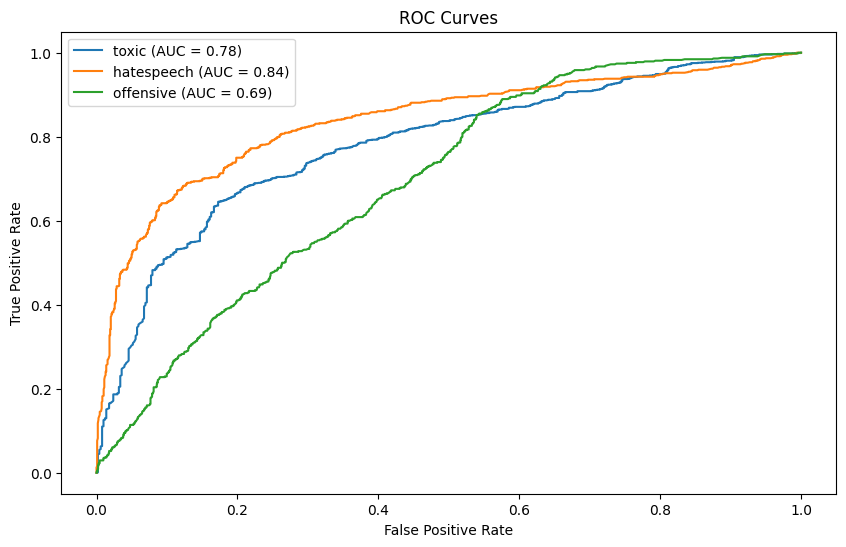

In [ ]:
# ROC curves
plt.figure(figsize=(10, 6))
for i, label in enumerate(labels_list):
    try:
        fpr, tpr, _ = roc_curve(labels[:, i], test_results.predictions[:, i])
        plt.plot(fpr, tpr, label=f"{label} (AUC = {metrics[f'roc_auc_{label}']:.2f})")
    except ValueError:
        continue  # Skip if ROC cannot be computed
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

In [ ]:
# Analyze false negatives for offensive
fn_indices = [i for i in range(len(labels)) if labels[i, 2] == 1 and predictions[i, 2] == 0]
fn_examples = [
    f"Text: {test_dataset['text'][i]}\nTrue Labels: {labels[i]}\nPredicted Labels: {predictions[i]}\nProbabilities: {torch.sigmoid(torch.tensor(test_results.predictions[i], dtype=torch.float32)).numpy()}\n"
    for i in fn_indices[:5]
]
print(f"\nFalse negatives for offensive: {len(fn_indices)} samples")
if fn_indices:
    print("Sample false negatives:")
    print("\n".join(fn_examples))


False negatives for offensive: 580 samples
Sample false negatives:
Text: <user> you are missing an essential premise whether any of those immigrants committed any crimes dumbass
True Labels: [1 0 1]
Predicted Labels: [ True False False]
Probabilities: [0.6525736  0.23318209 0.3706809 ]

Text: <user> <user> why are you repeating yourself are you a little retarded
True Labels: [1 0 1]
Predicted Labels: [False False False]
Probabilities: [0.44990614 0.1538032  0.38682136]

Text: yeah humnh what how do i use this app i ’ m alittle retarded 👹
True Labels: [1 0 1]
Predicted Labels: [ True False False]
Probabilities: [0.58788395 0.17852582 0.42030215]

Text: black people are oppressed by their own culture and community blacks need to wake and realize the democrats party is the racist party that uses them for votes the kk democrats have broken up the black family and run the community onto the ghetto plantation to control it youvebeenpunkd
True Labels: [1 0 1]
Predicted Labels: [ True False F

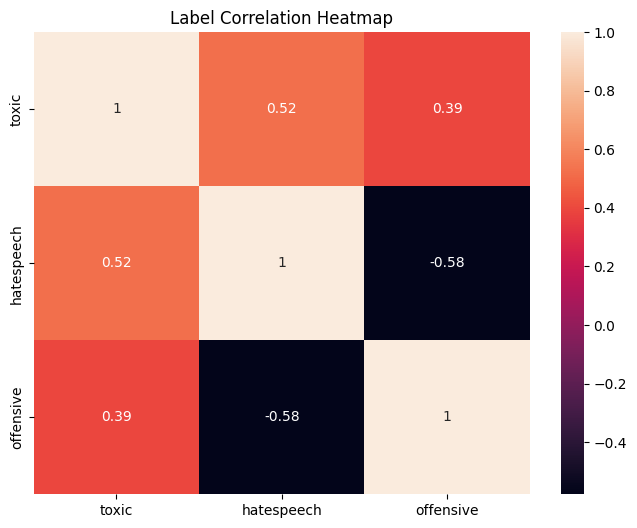

In [ ]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(np.corrcoef(labels.T), annot=True, xticklabels=labels_list, yticklabels=labels_list)
plt.title("Label Correlation Heatmap")
plt.show()


Offensive label sigmoid probabilities:
Mean: 0.3338, Std: 0.0827
Above 0.3: 1195 samples (62.11%)
Above 0.4: 544 samples (28.27%)
Above 0.5: 0 samples (0.00%)


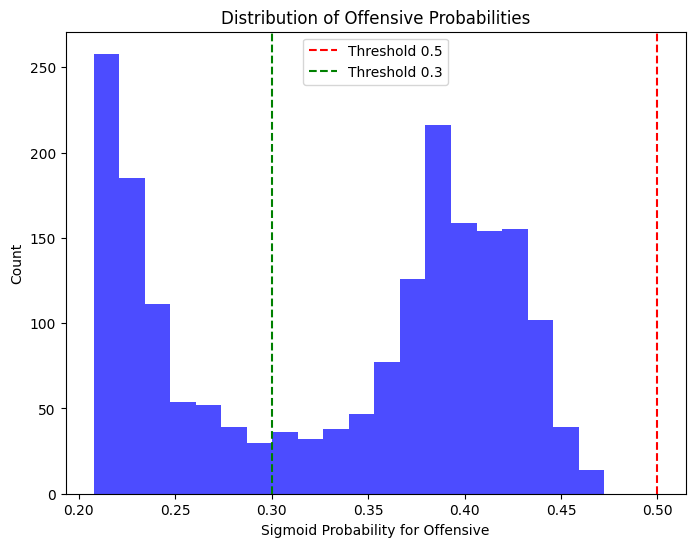

In [ ]:
# Analyze logits for offensive
offensive_logits = test_results.predictions[:, 2]  # Index 2 for offensive
offensive_probs = torch.sigmoid(torch.tensor(offensive_logits, dtype=torch.float32)).numpy()

print("\nOffensive label sigmoid probabilities:")
print(f"Mean: {offensive_probs.mean():.4f}, Std: {offensive_probs.std():.4f}")
for threshold in [0.3, 0.4, 0.5]:
    above_threshold = np.sum(offensive_probs > threshold)
    print(f"Above {threshold}: {above_threshold} samples ({above_threshold/len(offensive_probs)*100:.2f}%)")

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(offensive_probs, bins=20, color='blue', alpha=0.7)
plt.axvline(0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.axvline(0.3, color='green', linestyle='--', label='Threshold 0.3')
plt.xlabel("Sigmoid Probability for Offensive")
plt.ylabel("Count")
plt.title("Distribution of Offensive Probabilities")
plt.legend()
plt.show()

In [ ]:
# Save Model to Drive
save_path = "/content/drive/MyDrive/Experiments/distilbert_hatexplain_model"
Path(save_path).mkdir(parents=True, exist_ok=True)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/Experiments/distilbert_hatexplain_model/tokenizer_config.json',
 '/content/drive/MyDrive/Experiments/distilbert_hatexplain_model/special_tokens_map.json',
 '/content/drive/MyDrive/Experiments/distilbert_hatexplain_model/vocab.txt',
 '/content/drive/MyDrive/Experiments/distilbert_hatexplain_model/added_tokens.json',
 '/content/drive/MyDrive/Experiments/distilbert_hatexplain_model/tokenizer.json')

In [ ]:
# Push trained model to Huggingface
from huggingface_hub import login, create_repo, HfApi
from google.colab import userdata
import os

# Authenticate with Hugging Face
hf_token = userdata.get('hf_token')
login(token=hf_token)

# Create a new repository on Hugging Face (optional, skip if repo exists)
repo_id = "nivethithan-m/distilbert-hatexplain"  # Replace with your username and desired repo name
try:
    create_repo(repo_id=repo_id, repo_type="model", exist_ok=True)
except Exception as e:
    print(f"Repository creation failed or already exists: {e}")

In [ ]:
# Create model card
model_card_content = f"""
# DistilBERT Fine-Tuned on HateXplain for Multi-Label Toxicity Classification

## Model Description
This is a fine-tuned DistilBERT-base-uncased model for multi-label classification of online comments into three toxicity categories: `toxic`, `hatespeech`, and `offensive`. The model was trained on the HateXplain dataset to support automated content moderation. It uses LoRA (Low-Rank Adaptation) for efficient fine-tuning and a weighted BCE loss to handle label imbalance.

- **Base Model**: distilbert-base-uncased (66M parameters)
- **Task**: Multi-label classification
- **Labels**: {', '.join(labels_list)}
- **Training Date**: August 21, 2025
- **Repository**: [your_username/distilbert-hatexplain](https://huggingface.co/your_username/distilbert-hatexplain)

## Dataset
The model was trained on the [HateXplain dataset](https://huggingface.co/datasets/hatexplain), which contains ~20k social media posts annotated for toxicity by multiple annotators. Labels are mapped as follows:
- `hatespeech` (0) → [1, 1, 0] (toxic, hatespeech)
- `offensive` (2) → [1, 0, 1] (toxic, offensive)
- `normal` (1) → [0, 0, 0] (none)

### Label Distribution
**Training Set** (15,383 samples):
- toxic: 11,287 positive examples (73.37%)
- hatespeech: 6,608 positive examples (42.96%)
- offensive: 4,679 positive examples (30.42%)

**Validation Set** (1,922 samples):
- toxic: 1,398 positive examples (72.74%)
- hatespeech: 808 positive examples (42.04%)
- offensive: 590 positive examples (30.70%)

## Training
- **Architecture**: DistilBERT-base-uncased with LoRA (r=32, alpha=64, dropout=0.1, target modules: {config['lora_target_modules']})
- **Loss**: BCEWithLogitsLoss with class weights (boosted 10x for offensive, normalized)
- **Class Weights**:
  - toxic: {class_weights[0]:.6f}
  - hatespeech: {class_weights[1]:.6f}
  - offensive: {class_weights[2]:.6f}
- **Hyperparameters**:
  - Epochs: {config['epochs']}
  - Learning Rate: {config['lr']}
  - Batch Size: {config['batch_size']}
  - Gradient Accumulation Steps: {config['gradient_accumulation_steps']}
  - Weight Decay: {config['weight_decay']}
  - Max Sequence Length: {config['max_length']}
- **Hardware**: Google Colab T4 GPU (~60-120 minutes training time)

## Evaluation
Metrics from the best epoch (epoch 3):
- **Training Loss**: 0.520100
- **Validation Loss**: 0.514377
- **Micro F1**: 0.721122
- **Macro F1**: 0.530889
- **Accuracy**: 0.363163
- **Per-Label Metrics**:
  - F1 toxic: 0.845806
  - F1 hatespeech: 0.746861
  - F1 offensive: 0.000000
  - ROC-AUC toxic: 0.778115
  - ROC-AUC hatespeech: 0.851302
  - ROC-AUC offensive: 0.708620

### Offensive Label Analysis
The zero F1 score for `offensive` is due to no predictions exceeding the default 0.5 sigmoid threshold:
- **Sigmoid Probabilities**:
  - Mean: 0.3338
  - Std: 0.0827
  - Above 0.3: 1,195 samples (62.11%)
  - Above 0.4: 544 samples (28.27%)
  - Above 0.5: 0 samples (0.00%)

A lower threshold (0.25) was applied to increase recall for `offensive`, along with a 10x boosted class weight.

### False Negatives for Offensive
False negatives: {len(fn_indices)} samples
Sample false negatives:
{''.join(fn_examples)}

## Usage
Load the model and tokenizer:

```python
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained("{repo_id}")
tokenizer = AutoTokenizer.from_pretrained("{repo_id}")
model.eval()

text = "example text to classify"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
with torch.no_grad():
    logits = model(**inputs).logits
thresholds = [0.5, 0.5, 0.5]
predictions = (torch.sigmoid(logits) > torch.tensor(thresholds)).numpy()
labels = ["toxic", "hatespeech", "offensive"]
print(dict(zip(labels, predictions[0])))
```

## Limitations
The model struggles with the offensive label (F1=0.0), likely due to a high prediction threshold and class imbalance, despite 30.42% positive examples.
Ongoing improvements include further threshold tuning, data augmentation, and testing larger models (e.g., bert-base-uncased).
Majority voting improved label reliability, but annotator agreement needs verification.

## Acknowledgements
Dataset: HateXplain
Framework: Hugging Face Transformers
Training: Google Colab with T4 GPU
"""

with open(os.path.join(save_path, "README.md"), "w") as f:
    f.write(model_card_content)

In [ ]:
model.push_to_hub(repo_id, commit_message="Fine-tuned DistilBERT on HateXplain")
tokenizer.push_to_hub(repo_id, commit_message="Tokenizer for fine-tuned DistilBERT")
api = HfApi()
api.upload_file( path_or_fileobj=os.path.join(save_path, "README.md"), path_in_repo="README.md", repo_id=repo_id, repo_type="model", commit_message="Add model card", )
print(f"Model, tokenizer, and model card pushed to https://huggingface.co/{repo_id}")

# Analysis of Metrics

| Epoch | Training Loss | Validation Loss | Micro F1 | Macro F1 | Accuracy  | F1 Toxic | F1 Hatespeech | F1 Offensive | Roc Auc Toxic | Roc Auc Hatespeech | Roc Auc Offensive |
|-------|---------------|-----------------|----------|----------|-----------|----------|---------------|--------------|---------------|--------------------|-------------------|
| 1     | 0.587500      | 0.578290        | 0.701392 | 0.501840 | 0.242976  | 0.842169 | 0.663352      | 0.000000     | 0.730294      | 0.789940           | 0.657684          |
| 2     | 0.524800      | 0.525657        | 0.710225 | 0.522615 | 0.352758  | 0.839303 | 0.728542      | 0.000000     | 0.763064      | 0.836640           | 0.702199          |
| 3     | 0.520100      | 0.514377        | 0.721122 | 0.530889 | 0.363163  | 0.845806 | 0.746861      | 0.000000     | 0.778115      | 0.851302           | 0.708620          |

## Loss:
Training Loss: Decreases from 0.5875 to 0.5201, indicating the model is learning and optimizing on the training data.
Validation Loss: Decreases from 0.5783 to 0.5144, suggesting the model generalizes well to the validation set without significant overfitting (since validation loss tracks training loss closely).
Insight: The consistent reduction in both losses is a positive sign of learning progress. However, the loss values are still relatively high (>0.5), indicating potential for further optimization.


## Micro F1 (0.7014 → 0.7211):
Micro F1 aggregates predictions across all labels, weighting by instance count. The increase from 0.7014 to 0.7211 shows improved overall performance.
Insight: A Micro F1 of ~0.72 is decent for a multi-label task on a challenging dataset like HateXplain, but there’s room to aim for 0.75–0.80, common for well-tuned models in similar tasks.


## Macro F1 (0.5018 → 0.5309):
Macro F1 averages F1 scores across labels, treating each equally. The increase from 0.5018 to 0.5309 is positive, but the low value suggests poor performance on at least one label.
Insight: The Macro F1 is dragged down by the offensive label’s F1 score (0.0), indicating severe imbalance or model failure on this class.


## Accuracy (0.2430 → 0.3632):
Accuracy measures the proportion of examples where all labels are correctly predicted. The low values (0.24–0.36) are typical in multi-label tasks, as predicting all labels correctly is difficult.
Insight: Accuracy is less informative in multi-label settings due to partial correctness. Focus on F1 and ROC-AUC for better insight.


## Per-Label F1 Scores:
F1 Toxic (0.8422 → 0.8458): Strong performance, indicating the model effectively identifies toxic instances.
F1 Hatespeech (0.6634 → 0.7469): Moderate and improving, showing the model is learning to detect hatespeech but struggles compared to toxic.
F1 Offensive (0.0000): Consistently 0.0, indicating the model fails to predict any positive instances for offensive. This is a critical issue, likely due to label imbalance or mapping issues.
Insight: The zero F1 for offensive suggests the model is not learning this class, possibly because of sparse positive examples or an issue in the map_labels function.


## Per-Label ROC-AUC:
ROC-AUC Toxic (0.7303 → 0.7781): Good and improving, showing decent discriminative ability.
ROC-AUC Hatespeech (0.7899 → 0.8513): Strong and improving, indicating good separation of positive/negative instances.
ROC-AUC Offensive (0.6577 → 0.7086): Lower but improving, suggesting some discriminative ability despite zero F1.
Insight: ROC-AUC scores are higher than F1, indicating the model’s logits have some predictive power for offensive, but the 0.5 threshold in predictions is failing (likely due to imbalance).


# Are These Metrics Good?

## Strengths:
Decreasing loss and improving Micro/Macro F1 indicate the model is learning.
Strong performance on toxic (F1 ~0.85, ROC-AUC ~0.78) and decent performance on hatespeech (F1 ~0.75, ROC-AUC ~0.85) suggest the model is effective for these classes.
No significant overfitting (validation loss tracks training loss).


## Weaknesses:
Zero F1 for offensive is a major issue, indicating the model fails to predict this class, likely due to label imbalance or issues in the map_labels function.
Low Macro F1 (~0.53) reflects poor performance on offensive, as it averages across labels.
Low accuracy (0.36) is expected in multi-label tasks but suggests room for improvement in predicting all labels correctly.
ROC-AUC for offensive (0.71) is lower than others, indicating weaker discriminative power.



# Conclusion
The metrics are decent for toxic and hatespeech but poor for offensive, making the overall performance suboptimal for a multi-label classification task. A well-tuned model on HateXplain should aim for Micro F1 ≥ 0.75, Macro F1 ≥ 0.65, and non-zero F1 scores for all labels. The primary issue is the model’s failure on the offensive class, likely due to data imbalance or preprocessing.

# Why offensive F1 is Zero
The map_labels function maps HateXplain labels (0: hatespeech, 1: normal, 2: offensive) to [toxic, hatespeech, offensive] as follows:



```
hatespeech (0) → [1, 1, 0]
offensive (2) → [1, 0, 1]
normal (1) → [0, 0, 0]
```

# Possible reasons for zero F1 on offensive:
The threshold issue is a major contributor to the zero F1 score. Lowering the threshold for offensive (e.g., to 0.3 or lower) should increase positive predictions and improve F1.